# Metadata analysis of the MAST dataset

Reference: https://mastapp.site/

### Objectives:

* How many shots in the M9 campaign?
* Find label for each shot that tells if the shot is good or not? (how many shot left?)
* For a given shot, find labels for each diagnostic that tells if its a wrong one or not?
* A variable is called efit and refers to the EFIT++ reconstruction. See if there are information about the meaning of the variables.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import xarray as xr
import pathlib
import tqdm
from functools import partial
import os
import psutil
import time
import json
import pyarrow

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8
sns.set_palette('muted')

### 0. Visualization of the whole shots

In [14]:
URL = 'https://mastapp.site'

In [15]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')
shots_df

ArrowKeyError: A type extension with name pandas.period already defined

In [9]:
columns = shots_df.columns
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_df[col].dtype}")

NameError: name 'shots_df' is not defined

In [10]:
print(shots_df.loc[0, 'cpf_zmag_efit'])

NameError: name 'shots_df' is not defined

### 1. M9 campaign selection

In [12]:
shots_df_m9 = pd.read_parquet(f'{URL}/parquet/level2/shots?filters=campaign$eq:M9')
shots_df_m9

,context,url,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,commissioner,facility,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28752.zarr,\nChange ZREF to +1cm.\n,\n280ms shot.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.654442,8.727527,None,44755.881482,67405.750,None,None,None,None,0.032862
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28647.zarr,\nRepeat after abort.\n,\nGood 400kA 330ms plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,6.784744,9.231632,None,7209.400804,14854.986,None,None,None,None,-0.063345
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28750.zarr,\nChange zref to -1 cm\n,\n470ms shot. 400ms SS NBI. Sawteeth from 250m...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.083099,9.108404,None,44471.072260,72576.510,None,None,None,None,0.004665
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28631.zarr,"\nRepeat, with loop volts tweak and +-25kA P1P...",\nFirst plasma.\n,M9,400 kA,Conventional,None,None,MAST,...,5.389849,7.971025,None,1190.965664,3060.270,None,None,None,None,NaN
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28632.zarr,"\nRepeat, with -ve P1PS current limit 45kA. Tw...",\nGood plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,8.597655,8.830988,None,5577.911845,24692.621,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30467.zarr,\nRepeat with new neutron camera position.\ncH...,\nTwo times lower DD neutron rate than referen...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.029202,9.046394,None,49469.122469,52653.445,None,None,None,None,0.013202
1097,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30468.zarr,\nRepeat with new neutron camera position.\ncH...,\nGood beam.\nGood repeat.\n,M9,700 kA,Conventional,Lower Single Null,None,MAST,...,9.102411,9.107017,None,48516.962675,49382.133,None,None,None,None,0.012445
1098,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30469.zarr,\nRepeat with increased beam power (74 kV)\ncH...,\nGood shot. Modes present.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.988730,9.047923,None,47466.249616,49115.805,None,None,None,None,0.015299
1099,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30470.zarr,\nRepeat last using hydrogen in outboard and c...,\nNo HF gas.\n,M9,700 kA,Conventional,None,None,MAST,...,9.687049,10.055509,None,17290.432865,22310.516,None,None,None,None,0.015164


In [13]:
print(f"Number of shots in M9 campaign: {len(shots_df_m9)}")

Number of shots in M9 campaign: 1101


Find the list of the M9 campaign shot_id

In [14]:
m9_shot_ids = shots_df_m9['shot_id'].tolist()

print(f"Number of shot IDs in M9 campaign: {len(m9_shot_ids)}")
print("M9 campaign shot_id:", m9_shot_ids[:5])

Number of shot IDs in M9 campaign: 1101
M9 campaign shot_id: [28752, 28647, 28750, 28631, 28632]


*Conclusion :*

*The number of shots during the M9 campaign is 1101.*

*That represents 8.89 % of the 11281 shots over all campaign.*


### 2. Find labels for each shot

Interesting columns:
* `cpf_abort`: interupted shot if 1
* `cpf_useful`: good for analysis if 1

In [15]:
# Sélectionner les colonnes spécifiques
abort_values = shots_df_m9['cpf_abort']
useful_values = shots_df_m9['cpf_useful']

# Afficher les 5 premières valeurs (exemple)
print("Valeurs de cpf_abort :\n", abort_values.describe())
print("\nValeurs de cpf_useful :\n", useful_values.describe())

Valeurs de cpf_abort :
 count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: cpf_abort, dtype: float64

Valeurs de cpf_useful :
 count    755.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: cpf_useful, dtype: float64


In [16]:
good_shots = shots_df_m9.loc[(shots_df_m9['cpf_useful'] == 1) & (shots_df_m9['cpf_abort'] != 1)]
print(f"Number of good shots in M9 campaign: {len(good_shots)}")

Number of good shots in M9 campaign: 755


In [17]:
shots_df_m9['shot_label'] = (shots_df_m9['cpf_useful'] == 1).astype(int)
shots_df_m9[['shot_id','cpf_useful', 'cpf_abort', 'shot_label']]

,shot_id,cpf_useful,cpf_abort,shot_label
0,28752,1.0,NaN,1
1,28647,NaN,NaN,0
2,28750,1.0,NaN,1
3,28631,NaN,NaN,0
4,28632,NaN,NaN,0
...,...,...,...,...
1096,30467,1.0,NaN,1
1097,30468,1.0,NaN,1
1098,30469,1.0,NaN,1
1099,30470,NaN,NaN,0


Find the list of good shot_id and the list of bad shot_id.

In [18]:
good_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 1, 'shot_id'].tolist()
bad_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 0, 'shot_id'].tolist()

print(f"Number of good shot IDs: {len(good_shot_ids)}")
print("Good shot IDs:", good_shot_ids[:25])

print("\n")

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:5])

Number of good shot IDs: 755
Good shot IDs: [28752, 28750, 28655, 28656, 28657, 28744, 28751, 28747, 28748, 28749, 28755, 28757, 28758, 28763, 28801, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773]


Number of bad shot IDs: 346
Bad shot IDs: [28647, 28631, 28632, 28652, 28653]


### 3. Find label for each disgnostics (M9 campaign + magnetics)

Finding a label per diagnostic is quite more difficult.

1. We will first try to see if there are labels in the existant dataset.
2. If not, we will implement unsuvervised technics to label the dataset.

In [19]:
# Shot_id number for example
sh_id = 28752
#sh_id = 15585
grp = 'magnetics'

In [20]:
data = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
mag_var = data.data_vars
mag_var

Data variables:
    b_field_pol_probe_ccbv_field      (b_field_pol_probe_ccbv_channel, time) float64 741kB ...
    b_field_pol_probe_obr_field       (b_field_pol_probe_obr_channel, time) float64 334kB ...
    b_field_pol_probe_obv_field       (b_field_pol_probe_obv_channel, time) float64 334kB ...
    b_field_tor_probe_saddle_field    (b_field_tor_probe_saddle_field_channel, time_saddle) float64 2MB ...
    b_field_tor_probe_saddle_voltage  (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 2MB ...
    flux_loop_flux                    (flux_loop_channel, time) float64 278kB ...
    ip                                (time) float64 19kB ...

In [21]:
for var in mag_var:
    print(f"{var.ljust(35)}: {mag_var[var].attrs}")

b_field_pol_probe_ccbv_field       : {'description': 'Centre column Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'CCBV01', 'name': 'b_field_pol_probe_ccbv_field', 'uda_name': 'AMB_CCBV01', 'units': 'T'}
b_field_pol_probe_obr_field        : {'description': 'Outer Br array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'OBR01', 'name': 'b_field_pol_probe_obr_field', 'uda_name': 'AMB_OBR01', 'units': 'T'}
b_field_pol_probe_obv_field        : {'description': 'Outer Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'name': 'b_field_pol_probe_obv_field', 'units': 'T'}
b_field_tor_probe_saddle_field     : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].field.data', 'label': 'mT', 'name': 'b_field_tor_probe_saddle_field', 'uda_name': 'ASM_SAD/M01', 'units': 'T'}
b_field_tor_probe_saddle_voltage   : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].voltage.data', 'label': 'V', 'name': 'b_field_tor_probe_saddle_volt

In [22]:
data['ip']['time'].values

array([-0.10280025, -0.10260025, -0.10240025, ...,  0.35979975,
        0.35999975,  0.36019975], shape=(2316,))

In [23]:
signals_df = pd.read_parquet(f"{URL}/parquet/level2/signals?shot_id={sh_id}")
signals_df.head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,1ef217e3-12b0-5523-bfbf-f466db059e31,beta_normal,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,294c6905-fba4-5682-b8e0-047000ee5098,beta_pol,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,ed36483e-c8b5-56e1-9b92-67c9acd13e12,beta_tor,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,12feafef-7d0f-59a5-a5a7-226739e9008c,bphi_rmag,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752


In [24]:
signals_df.loc[4]

context         {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...
shape                                                        [93]
provenance                                                   None
description                                                      
dimensions                                                 [time]
quality                                               Not Checked
type                                                 dcat:Dataset
title                                              Signal Dataset
uuid                         12feafef-7d0f-59a5-a5a7-226739e9008c
name                                                    bphi_rmag
version                                                         0
rank                                                            1
url                             s3://mast/level2/shots/28752.zarr
endpoint_url                           https://s3.echo.stfc.ac.uk
source                                                equilibrium
units     

In [25]:
signals_df.loc[signals_df['imas']=='magnetics'].head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
35,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[40, 2316]",None,,"[b_field_pol_probe_ccbv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,586ebaa8-2901-5ccb-a88f-c91b7fa469af,b_field_pol_probe_ccbv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
36,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obr_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,4db8b61d-8d92-5f24-885e-114be1ad0775,b_field_pol_probe_obr_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
37,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,63fce13c-2ed9-5378-aa29-03c5a457f4a1,b_field_pol_probe_obv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
38,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[12, 23160]",None,,"[b_field_tor_probe_saddle_field_channel, time_...",Not Checked,dcat:Dataset,Signal Dataset,d9a3b4c0-06be-58fc-95b8-9891253e7d12,b_field_tor_probe_saddle_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752


In [26]:
shot_data = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()
for key, value in shot_data.items():
    if isinstance(value, list):
        print(f"{key.ljust(30)}: {len(value)} items")
    else:
        print(f"{key.ljust(30)}: {value}")

@context                      : {'dct': 'http://purl.org/dc/terms/', 'dqv': 'http://www.w3.org/ns/dqv#', 'url': 'schema:url', 'dcat': 'http://www.w3.org/ns/dcat#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'uuid': 'dct:identifier', 'title': 'dct:title', 'schema': 'https://schema.org', 'timestamp': 'dct:date', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#'}
@type                         : dcat:Dataset
title                         : Shot Dataset
shot_id                       : 28752
uuid                          : 2bd7255e-9f9e-59ba-8968-6ece568e5755
url                           : s3://mast/level1/shots/28752.zarr
endpoint_url                  : https://s3.echo.stfc.ac.uk
timestamp                     : 2013-05-20T13:30:00
preshot_description           : 
Change ZREF to +1cm.

postshot_description          : 
280ms shot.

campaign                      : M9
reference_shot                : 28751
scenario                      : 3
heating                       : Ohmic
pellets

In [27]:
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)
print(f"Shot URL: {shot_url}")

Shot URL: https://s3.echo.stfc.ac.uk/mast/level1/shots/28752.zarr


*Conclusion :*

*Nothing here seems to be a good label for each diagnostic.*

*Update: After speaking with Samuel Jackson, there are in fact no label available for each diagnostics. But also, the shots' labels are kind of subjective and hand-crafted.*

*Update 2:* In "context", we have that key:value = 'quality': 'qdv:QualityAnnotation' We might search behind *qdv:QualityAnnotation*.

### 4. EFIT++ information meaning

In [51]:
sh_id = 28752
sh_id = 15585
sh_id = 26320

grp = 'equilibrium'

In [61]:
data_eq_all_sh = pd.read_parquet(f'{URL}/parquet/level2/shots')
print("Columns in data_eq_all_sh:")
for col in data_eq_all_sh.columns:
    print(f"{col.ljust(25)}: {data_eq_all_sh[col].dtype}:            {data_eq_all_sh[col].shape}:              {data_eq_all_sh[col].iloc[0]}")



Columns in data_eq:
context                  : object:            (11281,):              {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': 'http://purl.org/dc/terms/', 'dqv': 'http://www.w3.org/ns/dqv#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'schema': 'https://schema.org', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#', 'timestamp': 'dct:date', 'title': 'dct:title', 'url': 'schema:url', 'uuid': 'dct:identifier'}
url                      : object:            (11281,):              s3://mast/level2/shots/11766.zarr
preshot_description      : object:            (11281,):              
RELOAD 10232 PLASMA CONDITIONING SHOT FROM M4

postshot_description     : object:            (11281,):              
GOOD PLASMA, RAN FINE. SL JOINT ALARMS RATHER HIGH

campaign                 : object:            (11281,):              M5
current_range            : object:            (11281,):              None
divertor_config          : object:            (11281,):              Conventional


In [62]:
data_eq_all_src = pd.read_parquet(f'{URL}/parquet/level2/sources')
print("Columns in data_eq_all_src:")
for col in data_eq_all_src.columns:
    print(f"{col.ljust(25)}: {data_eq_all_src[col].dtype}:            {data_eq_all_src[col].shape}:              {data_eq_all_src[col].iloc[0]}")

Columns in data_eq:
context                  : object:            (103166,):              {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': 'http://purl.org/dc/terms/', 'description': 'dct:description', 'dqv': 'http://www.w3.org/ns/dqv#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'name': 'schema:name', 'quality': 'qdv:QualityAnnotation', 'schema': 'https://schema.org', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#', 'title': 'dct:title', 'url': 'schema:url', 'uuid': 'dct:identifier'}
description              : object:            (103166,):              
quality                  : object:            (103166,):              Not Checked
type                     : object:            (103166,):              dcat:Dataset
title                    : object:            (103166,):              Source Dataset
uuid                     : object:            (103166,):              0f3fbb3a-8915-593b-8a5e-bb2801bd5b6d
name                     : object:            (103166,):              equ

In [63]:
data_eq_all_sig = pd.read_parquet(f'{URL}/parquet/level2/signals?shot_id={sh_id}')
print("Columns in data_eq_all_sig:")
for col in data_eq_all_sig.columns:
    print(f"{col.ljust(25)}: {data_eq_all_sig[col].dtype}:            {data_eq_all_sig[col].shape}:              {data_eq_all_sig[col].iloc[0]}")

Columns in data_eq_all_sig:
context                  : object:            (69,):              {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': 'http://purl.org/dc/terms/', 'description': 'dct:description', 'dqv': 'http://www.w3.org/ns/dqv#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'name': 'schema:name', 'quality': 'qdv:QualityAnnotation', 'schema': 'https://schema.org', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#', 'source': 'dct:source', 'title': 'dct:title', 'url': 'schema:url', 'uuid': 'dct:identifier', 'version': 'schema:version'}
shape                    : object:            (69,):              [252]
provenance               : object:            (69,):              None
description              : object:            (69,):              
dimensions               : object:            (69,):              ['time']
quality                  : object:            (69,):              Not Checked
type                     : object:            (69,):              dcat:Dataset
ti

In [64]:
data_eq_1_sh = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
print(f"Data variables in data_eq_1_sh: ")
eq_var = data_eq_1_sh.data_vars
eq_var

Data variables in data_eq_1_sh: 


Data variables:
    beta_normal          (time) float64 2kB ...
    beta_pol             (time) float64 2kB ...
    beta_tor             (time) float64 2kB ...
    bphi_rmag            (time) float64 2kB ...
    bvac_rmag            (time) float64 2kB ...
    da_rating            (time) float64 2kB ...
    elongation           (time) float64 2kB ...
    elongation_axis      (time) float64 2kB ...
    ip_rating            (time) float64 2kB ...
    j_tor                (time, z, major_radius) float64 9MB ...
    lcfs_r               (time, n_boundary_coords) float64 292kB ...
    lcfs_z               (time, n_boundary_coords) float64 292kB ...
    li                   (time) float64 2kB ...
    magnetic_axis_r      (time) float64 2kB ...
    magnetic_axis_z      (time) float64 2kB ...
    minor_radius         (time) float64 2kB ...
    psi                  (time, z, major_radius) float64 9MB ...
    q                    (time, profile_r) float64 131kB ...
    q100                 (time)

In [65]:
eq_coord = data_eq_1_sh.coords
eq_coord

Coordinates:
  * major_radius       (major_radius) float64 520B 0.06 0.09 0.12 ... 1.95 1.98
  * n_boundary_coords  (n_boundary_coords) float32 580B 0.0 1.0 ... 143.0 144.0
  * n_x_points         (n_x_points) <U16 256B 'EFM_XPOINT1_R(C)' ... 'EFM_XPO...
  * profile_r          (profile_r) float32 260B 0.0 0.01562 ... 0.9844 1.0
  * time               (time) float64 2kB -0.4608 -0.4558 ... 0.7892 0.7942
  * z                  (z) float32 260B -2.0 -1.938 -1.875 ... 1.875 1.938 2.0

In [66]:
data_eq_1_sh["psi"].attrs

{'description': '',
 'imas': 'equilibrium.time_slice[:].profiles_2d[:].psi',
 'label': 'psi(r,z)',
 'name': 'psi',
 'uda_name': 'EFM_PSI(R,Z)',
 'units': 'Wb / rad'}

In [67]:
data_eq_1_sh["psi"].values[100]

array([[0.00038638, 0.00086685, 0.00153275, ..., 0.00330089, 0.00301806,
        0.00275437],
       [0.00046341, 0.0010403 , 0.00184113, ..., 0.00288405, 0.00259976,
        0.00233654],
       [0.0005515 , 0.0012376 , 0.00218985, ..., 0.00234794, 0.00207251,
        0.00181878],
       ...,
       [0.00058527, 0.00131555, 0.00233335, ..., 0.00662314, 0.00618463,
        0.00578194],
       [0.00049538, 0.00111266, 0.00197022, ..., 0.0072327 , 0.00677648,
        0.0063575 ],
       [0.00041507, 0.00093144, 0.00164746, ..., 0.00762706, 0.00717949,
        0.00676557]], shape=(65, 65))

#### *Conclusion*

There are nothing that could help us find the score given to the EFIT++ reconstruction.

The paths might be farther explored:
1. in the `context` dictionnary for each source of each shot: the key `quality`.
2. in the shot level 1 variables: `cpf_rinner_efit`, `cpf_router_efit`, `cpf_rmag_efit`, `cpf_zmag_efit`

In [68]:
sh_id = 28752
grp = 'efm'

data_eq_1_sh = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level1/shots/{sh_id}.zarr",
    group=grp,
)
print(f"Data variables in data_eq_1_sh: ")
eq_var = data_eq_1_sh.data_vars
eq_var

Data variables in data_eq_1_sh: 


Data variables:
    all_times          (time) float32 284B ...
    areap_c            (time, psi_norm) float32 18kB ...
    betan              (time) float32 284B ...
    betap              (time) float32 284B ...
    betapd             (time) float32 284B ...
    betat              (time) float32 284B ...
    betatd             (time) float32 284B ...
    bphi_rgeom         (time) float32 284B ...
    bphi_rmag          (time) float32 284B ...
    bphi_squared       (time) float32 284B ...
    bpol_squared       (time) float32 284B ...
    bvac_r             (time) float32 284B ...
    bvac_rgeom         (time) float32 284B ...
    bvac_rmag          (time) float32 284B ...
    bvac_val           (time) float32 284B ...
    chisq_magnetic     (time, n_iterations) float32 3kB ...
    cm_bdry            (time) float32 284B ...
    cnvrgd_times       (time) float32 284B ...
    current_centrd_r   (time) float32 284B ...
    current_centrd_z   (time) float32 284B ...
    cutip            

In [86]:
data_eq_1_sh["fwtmp"]



<xarray.DataArray 'fwtmp' (time: 71, mag_probe_n: 78)> Size: 22kB
[5538 values with dtype=float32]
Coordinates:
  * mag_probe_n  (mag_probe_n) float32 312B 0.0 1.0 2.0 3.0 ... 75.0 76.0 77.0
  * time         (time) float32 284B -0.05 -0.045 -0.04 ... 0.295 0.3 0.305
Attributes: (12/18)
    description:  Magnetic detector fit weights; f(magpr_n)
    dims:         ['time', 'mag_probe_n']
    file_name:    None
    format:       None
    label:        fit weight of mag signal
    mds_name:     \TOP.ANALYSED.EFM:FWTMP
    ...           ...
    source:       efm
    time_index:   0
    uda_name:     EFM_FWTMP
    units:        
    uuid:         0e67a265-dfd5-5c00-9a7f-24d9f4a8678f
    version:      0

### 5. Is `shot_id` crescent with the `timestamp` ?

In [33]:
sh_id = 28752
sh_id = 15585

In [34]:
shot_timestamp = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()["timestamp"]
shot_timestamp

'2006-06-08T12:57:00'

In [11]:
URL = 'https://mastapp.site'
shots_order = pd.read_parquet(f'{URL}/parquet/level2/shots') 

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [36]:
columns = shots_order.columns 
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_order[col].dtype}")

Number of columns: 290

context                  : object
url                      : object
preshot_description      : object
postshot_description     : object
campaign                 : object
current_range            : object
divertor_config          : object
plasma_shape             : object
commissioner             : object
facility                 : object
type                     : object
title                    : object
shot_id                  : int64
uuid                     : object
endpoint_url             : object
timestamp                : datetime64[ns]
reference_shot           : float64
scenario                 : float64
heating                  : object
pellets                  : object
rmp_coil                 : object
cpf_p03249               : object
cpf_p04673               : object
cpf_p04674               : object
cpf_p04675               : object
cpf_p04676               : object
cpf_p04677               : object
cpf_p04678               : object
cpf_p04679     

In [37]:
sorted_order = shots_order.sort_values("timestamp")

In [38]:
is_sorted = sorted_order["shot_id"].is_monotonic_increasing
print(f"Shot IDs are sorted by timestamp: {is_sorted}")

Shot IDs are sorted by timestamp: False


In [ ]:
if not is_sorted:
    diffs = sorted_order["shot_id"].diff().fillna(1)
    non_increasing = sorted_order[diffs <= 0]
    print("Number of non-increasing shot_ids: ", len(non_increasing), "\n")
    print("Non-increasing shot_ids:")
    non_increasing_list = non_increasing[["timestamp", "shot_id"]].values.tolist()
    for ts, shot_id in non_increasing_list:
        print(f"Timestamp: {ts}, Shot ID: {shot_id}")

    file_path = "notebooks/result_files/non_increasing"
    suffix = ""
    path = pathlib.Path().absolute().parent.parent.parent / file_path / f"non_increasing_shot_id{suffix}.csv"
    non_increasing_list = pd.Series(non_increasing_list)
    non_increasing_list.to_csv(path, index=False)

Number of non-increasing shot_ids:  21 

Non-increasing shot_ids:
Timestamp: 2006-06-13 13:08:00, Shot ID: 15632
Timestamp: 2006-07-25 09:15:00, Shot ID: 15951
Timestamp: 2006-08-22 09:20:00, Shot ID: 16310
Timestamp: 2007-01-18 10:29:00, Shot ID: 16847
Timestamp: 2007-07-18 08:51:00, Shot ID: 18882
Timestamp: 2008-06-25 09:49:00, Shot ID: 19536
Timestamp: 2008-07-10 09:12:00, Shot ID: 19700
Timestamp: 2008-09-11 10:22:00, Shot ID: 20294
Timestamp: 2008-10-28 13:52:00, Shot ID: 20722
Timestamp: 2008-11-13 09:55:00, Shot ID: 20909
Timestamp: 2008-11-26 17:54:00, Shot ID: 20972
Timestamp: 2009-02-25 10:50:00, Shot ID: 21433
Timestamp: 2009-05-19 11:07:00, Shot ID: 22376
Timestamp: 2009-10-13 09:17:00, Shot ID: 23336
Timestamp: 2009-12-17 00:00:00, Shot ID: 23943
Timestamp: 2009-12-17 13:09:00, Shot ID: 23927
Timestamp: 2010-01-28 09:44:00, Shot ID: 24194
Timestamp: 2011-04-12 09:13:00, Shot ID: 25732
Timestamp: 2011-06-24 09:36:00, Shot ID: 26397
Timestamp: 2011-07-10 23:00:00, Shot ID: 

Plot saved to c:\Users\brussel\Documents\1.ITER_Internship\ITER-magnetics-diagnostic-analysis\src\magnetics_diagnostic_analysis\results\non_increasing\non_increasing_shot_ids_plot.png


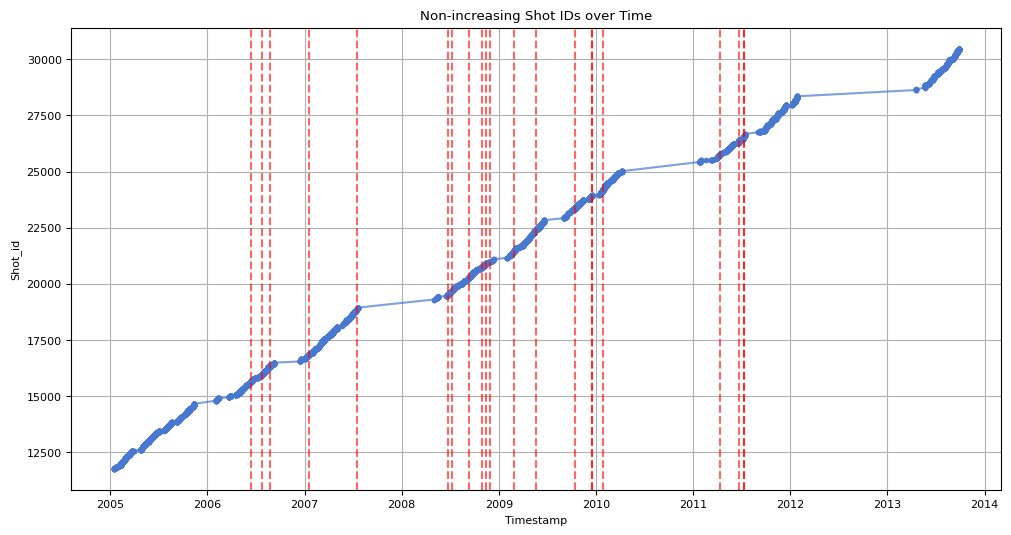

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(sorted_order["timestamp"], sorted_order["shot_id"], marker='.', linestyle='-', alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Shot_id")
plt.title("Non-increasing Shot IDs over Time")
plt.grid(True)

# Red vertical lines for non-increasing shot_ids
for ts in non_increasing["timestamp"]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.6)

# Registration
file_path = f"notebooks/result_files/non_increasing"
register_name = "non_increasing_shot_ids_plot.png"
path = pathlib.Path().absolute().parent.parent.parent / file_path / register_name
plt.savefig(path, dpi="figure")
print(f"Plot saved to {path}")

# Visualization
plt.show()

*Conclusion :*

*The number of non-increasing shot_id through time is negligeable in comparison with the number of shots.*

### 6. Analysis of NaN apparition through time

In [12]:
def to_dask(shot: int, group: str, level: int = 2) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Data level to retrieve (default is 2).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [13]:
a = to_dask(
    shot=12434,
    group='summary',
)
a

<xarray.Dataset> Size: 129kB
Dimensions:              (time: 2308)
Coordinates:
  * time                 (time) float64 18kB -0.066 -0.06575 ... 0.5105 0.5107
Data variables:
    greenwald_density    (time) float64 18kB ...
    ip                   (time) float64 18kB ...
    line_average_n_e     (time) float64 18kB ...
    neutron_rates_total  (time) float64 18kB ...
    power_nbi            (time) float64 18kB ...
    power_radiated       (time) float64 18kB ...
Attributes:
    description:  
    imas:         summary
    label:        Plasma Current
    name:         summary
    uda_name:     AMC_PLASMA CURRENT
    units:        A

In [83]:
def build_variable_vs_timestamp(
    shots: list[int],
    group: str,
    variable: str,
    verbose: bool = False
) -> xr.Dataset:
    """
    Concat data from a variable across multiple shots, aligned in absolute time based on the start timestamp of each shot.
    
    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    variable: str
        Name of the variable to be retrieved.
    verbose: bool
        Displays messages for debugging or tracking.

    Returns
    xr.Dataset
        Dataset containing the variable concatenated across all shots, based on the actual timestamp.
    """
    all_data = []

    for shot_id in tqdm.tqdm(shots, desc="Loading shots", total=len(shots)):
        try:
            # Load data
            ds = to_dask(shot_id, group)
            if variable not in ds:
                if verbose:
                    print(f"Variable {variable} not in group {group} for shot {shot_id}")
                continue
            da = ds[variable]

            # Get timestamp of shot begining
            meta = requests.get(f"https://mastapp.site/json/shots/{shot_id}").json()
            t0 = pd.to_datetime(meta["timestamp"]).timestamp()  # UNIX timestamp (secondes))

            time_dim = next((dim for dim in da.dims if dim.startswith("time")), None)
            if time_dim is None:
                if verbose:
                    print(f"Aucune dimension temporelle pour {variable} dans shot {shot_id}")
                continue

            # Absolute time (secondes since UNIX) and then convert to datetime
            relative_time = ds[time_dim].values.astype(np.float64)  # secondes
            global_time = pd.to_datetime(t0 + relative_time, unit='s')  # Convert to datetime

            # New array with global time
            coords = {"time": global_time}
            dims = ("time",)
            if da.ndim == 2:
                chan_dim = [dim for dim in da.dims if dim != time_dim][0]
                coords[chan_dim] = ds[chan_dim]
                dims = ("time", chan_dim)

            da_new = xr.DataArray(
                da.values,
                dims=dims,
                coords=coords,
                attrs=da.attrs
            )

            all_data.append(da_new)

        except Exception as e:
            if verbose:
                print(f"Erreur avec le shot {shot_id}: {e}")
            continue

    result = xr.concat(all_data, dim="time").sortby("time")

    return xr.Dataset({variable: result})

In [84]:
def check_variable_presence_by_channel(
    shots: list[int],
    group: str,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Check presence of all variables (and their channels) across shots in a group.

    Returns a DataFrame where:
    - Rows = variable::channel (or variable if 1D)
    - Columns = shot_id
    - Values = True (present and not NaN), None (only NaNs), False (missing)
    """
    var_presence: dict[str, dict[int, bool | None]] = {}
    seen_shots = []

    for shot_id in tqdm.tqdm(shots, desc="Checking variables", total=len(shots)):
        try:
            ds = to_dask(shot_id, group)
            shot_vars = set(ds.data_vars)

            for var in shot_vars:
                da = ds[var]
                other_dims = [dim for dim in da.dims if not dim.startswith("time")]

                # 1D variable (just time)
                if len(other_dims) == 0:
                    key = var
                    if key not in var_presence:
                        var_presence[key] = {s: False for s in seen_shots}

                    if np.issubdtype(da.dtype, np.floating):
                        all_nan = np.isnan(da.values).all()
                        var_presence[key][shot_id] = None if all_nan else True
                    else:
                        var_presence[key][shot_id] = True

                # 2D variable: split per channel
                elif len(other_dims) == 1:
                    chan_dim = other_dims[0]
                    if chan_dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {chan_dim} not found in coords for {var} in shot {shot_id}")
                        continue

                    for chan in ds[chan_dim].values:
                        key = f"{var}::{chan}"
                        if key not in var_presence:
                            var_presence[key] = {s: False for s in seen_shots}

                        try:
                            slice_da = da.sel({chan_dim: chan})
                            if np.issubdtype(slice_da.dtype, np.floating):
                                all_nan = np.isnan(slice_da.values).all()
                                var_presence[key][shot_id] = None if all_nan else True
                            else:
                                var_presence[key][shot_id] = True
                        except Exception as e:
                            if verbose:
                                print(f"Error accessing {key} in shot {shot_id}: {e}")
                            var_presence[key][shot_id] = False
                else:
                    if verbose:
                        print(f"Skipping variable with unexpected dims: {var} -> {da.dims}")
                    continue

            # Mark missing variables/channels as False: case where there was a "continue"
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False

            seen_shots.append(shot_id)

        except Exception as e:
            if verbose:
                print(f"Error processing shot {shot_id}: {e}")
            # Mark all known vars as False
            for key in var_presence:
                var_presence[key][shot_id] = False

    df = pd.DataFrame(var_presence).T
    return df

In [85]:
def check_variable_presence_by_channel_vectorized(
    shots: list[int],
    group: str,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Check presence of all variables (and their channels) across shots in a group.
    Vectorized version for better performance.
    
    Returns a DataFrame where:
    - Rows = variable::channel (or variable if 1D)
    - Columns = shot_id
    - Values = True (present and not NaN), None (only NaNs), False (missing)
    """
    var_presence = {}
    seen_shots = []

    for shot_id in tqdm.tqdm(shots, desc="Checking variables", total=len(shots)):
        try:
            ds = to_dask(shot_id, group)
            shot_vars = set(ds.data_vars)

            for var in shot_vars:
                da = ds[var]
                time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
                
                if not time_dims:
                    if verbose:
                        print(f"Skipping {var} with no time dimension: {da.dims}")
                    continue
                
                time_dim = time_dims[0]  # First dimension containing 'time'
                other_dims = [dim for dim in da.dims if dim != time_dim]

                # 1. Variable 1D (just time)
                if not other_dims:
                    key = var
                    if key not in var_presence:
                        var_presence[key] = {s: False for s in seen_shots}
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            has_valid = da.notnull().any().compute()
                            var_presence[key][shot_id] = True if has_valid else None
                        else:
                            # For non-floating types, we assume presence if the variable exists.
                            var_presence[key][shot_id] = True
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        var_presence[key][shot_id] = False

                # 2. Variable 2D: split per channel
                else:
                    for dim in other_dims:
                        if dim not in ds.coords:
                            if verbose:
                                print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                            continue
                        
                        try:
                            if np.issubdtype(da.dtype, np.floating):
                                channel_has_data = da.notnull().any(dim=time_dim)
                            else:
                                # For non-floating types, we assume presence if the variable exists.
                                channel_has_data = xr.ones_like(ds[dim], dtype=bool)
                            
                            channel_results = channel_has_data.compute()
                            
                            for coord_val in ds[dim].values:
                                key = f"{var}::{coord_val}"
                                if key not in var_presence:
                                    var_presence[key] = {s: False for s in seen_shots}
                                
                                try:
                                    chan_valid = channel_results.sel({dim: coord_val}).item()
                                    var_presence[key][shot_id] = True if chan_valid else None
                                except Exception as e:
                                    if verbose:
                                        print(f"Error accessing {coord_val} in {var}: {e}")
                                    var_presence[key][shot_id] = False
                        
                        except Exception as e:
                            if verbose:
                                print(f"Error processing {var} in shot {shot_id}: {e}")
                            for coord_val in ds[dim].values:
                                key = f"{var}::{coord_val}"
                                if key not in var_presence:
                                    var_presence[key] = {s: False for s in seen_shots}
                                var_presence[key][shot_id] = False

            # Missing variables/channels: case where there was a "continue"
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False
            
            seen_shots.append(shot_id)
            
        except Exception as e:
            if verbose:
                print(f"Error processing shot {shot_id}: {e}")
            for key in var_presence:
                var_presence[key][shot_id] = False

    return pd.DataFrame(var_presence).T

In [ ]:
def retry_to_dask(shot_id, group, retries=3, delay=1):
    """
    Retry loading a shot's data as a Dask Dataset with exponential backoff.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    retries: Number of retry attempts (default is 3).
    delay: Delay in seconds between retries (default is 5).

    Returns
    xr.Dataset
        The Dask Dataset for the specified shot and group.
    or Error
    """
    for attempt in range(retries):
        try:
            return to_dask(shot_id, group)
        except Exception as e:
            if attempt < retries - 1:
                print(f"Retrying connection to {shot_id} in group {group} (attempt {attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                raise e



def process_shot(shot_id, group, verbose=False):
    """
    Process a single shot, returning a dictionary of results.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    verbose: bool
        Displays messages for debugging or tracking.
    
    Returns
    shot_id: int
        The shot ID processed.
    shot_result: dict
        Dictionary containing the presence of variables and their channels:
    """
    shot_result = {}
    try:
        ds = retry_to_dask(shot_id, group)
        shot_vars = set(ds.data_vars)

        for var in shot_vars:
            da = ds[var]
            time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
            
            if not time_dims:
                if verbose:
                    print(f"Skipping {var} with no time dimension: {da.dims}")
                continue
            
            time_dim = time_dims[0]
            other_dims = [dim for dim in da.dims if dim != time_dim]

            # 1. Variable 1D
            if not other_dims:
                key = var
                try:
                    if np.issubdtype(da.dtype, np.floating):
                        has_valid = da.notnull().any().compute()
                        shot_result[key] = True if has_valid else None
                    else:
                        # For non-floating types, we assume presence if the variable exists.
                        shot_result[key] = True
                except Exception as e:
                    if verbose:
                        print(f"Error processing {var} in shot {shot_id}: {e}")
                    shot_result[key] = False

            # 2. Variable 2D
            else:
                for dim in other_dims:
                    if dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                        continue
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            channel_has_data = da.notnull().any(dim=time_dim)
                        else:
                            # For non-floating types, we assume presence if the variable exists.
                            channel_has_data = xr.ones_like(ds[dim], dtype=bool)
                        
                        channel_results = channel_has_data.compute()
                        
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            try:
                                chan_valid = channel_results.sel({dim: coord_val}).item()
                                shot_result[key] = True if chan_valid else None
                            except Exception as e:
                                if verbose:
                                    print(f"Error accessing {coord_val} in {var}: {e}")
                                shot_result[key] = False
                    
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            shot_result[key] = False

    except Exception as e:
        if verbose:
            print(f"Error processing shot {shot_id}: {e}")
        shot_result = {}

    return shot_id, shot_result



def get_optimal_workers(task_type="cpu"):
    """
    Get the optimal number of workers for parallel processing based on the task type.

    Parameters
    task_type: str
        Type of task to determine the optimal number of workers (only possibility is "cpu").

    Returns the optimal number of workers based on the task type.
    """
    cpu_logical = os.cpu_count()
    
    if task_type == "cpu":
        try:
            return psutil.cpu_count(logical=False)
        except:
            return max(1, cpu_logical // 2)  # Default to half of logical cores
    else:
        return max(1, cpu_logical - 1) # Default to one less than logical cores
    


def check_variable_presence_parallel(
    shots: list[int],
    group: str,
    verbose: bool = False,
    max_workers: int = None
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers()
    print(f"Use of {max_workers} workers (type: cpu)")
    
    var_presence = {}
    seen_shots = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot, group=group, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            concurrent.futures.as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_id, shot_result = future.result()
            seen_shots.append(shot_id)
            
            for key, present in shot_result.items():
                if key not in var_presence:
                    var_presence[key] = {s: False for s in seen_shots}
                var_presence[key][shot_id] = present
            
            # Mark missing variables/channels as False: case where there was a "continue" in process_shot.
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False

    df = pd.DataFrame(var_presence).T
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df

In [87]:
URL = 'https://mastapp.site'
shots_disappearance = pd.read_parquet(f'{URL}/parquet/level2/shots')
sorted_disappearance = shots_disappearance.sort_values("timestamp")
shots = sorted_disappearance['shot_id'].tolist()
print("Number of shots: ", len(shots))

Number of shots:  11281


In [ ]:
group = 'magnetics'
variable = 'ip'

In [1]:
group = 'summary'

In [89]:
variable_vs_timestamp = build_variable_vs_timestamp(
    shots=shots[:10], 
    group=group, 
    variable=variable, 
    verbose=True)

Loading shots: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


In [90]:
variable_presence = check_variable_presence_by_channel(
    shots=shots[:10], 
    group=group, 
    verbose=True)

Checking variables: 100%|██████████| 10/10 [02:08<00:00, 12.80s/it]


In [91]:
variable_presence_vectorized = check_variable_presence_by_channel_vectorized(
    shots=shots[:10], 
    group=group, 
    verbose=True)

Checking variables: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


In [2]:
variable_presence_parallel= check_variable_presence_parallel(
    shots=shots[:10], 
    group=group, 
    verbose=True,
    max_workers=None)

NameError: name 'check_variable_presence_parallel' is not defined

#### Analysing the results

In [93]:
variable_vs_timestamp

<xarray.Dataset> Size: 365kB
Dimensions:  (time: 22795)
Coordinates:
  * time     (time) datetime64[ns] 182kB 2005-01-13T12:01:59.932800055 ... 20...
Data variables:
    ip       (time) float64 182kB 5.039e+03 5.184e+03 ... -2.33e+03 -2.33e+03

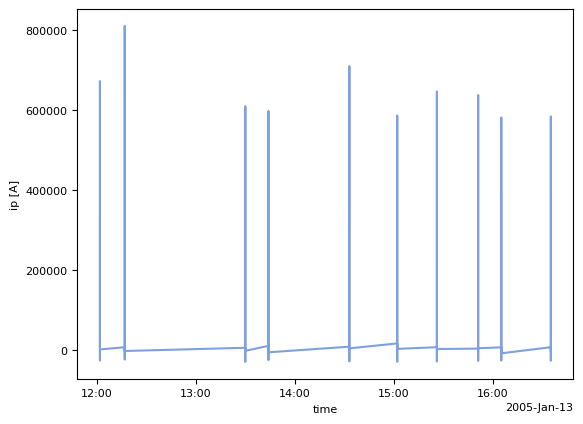

In [94]:
variable_vs_timestamp[variable].plot(x="time", alpha=0.7)

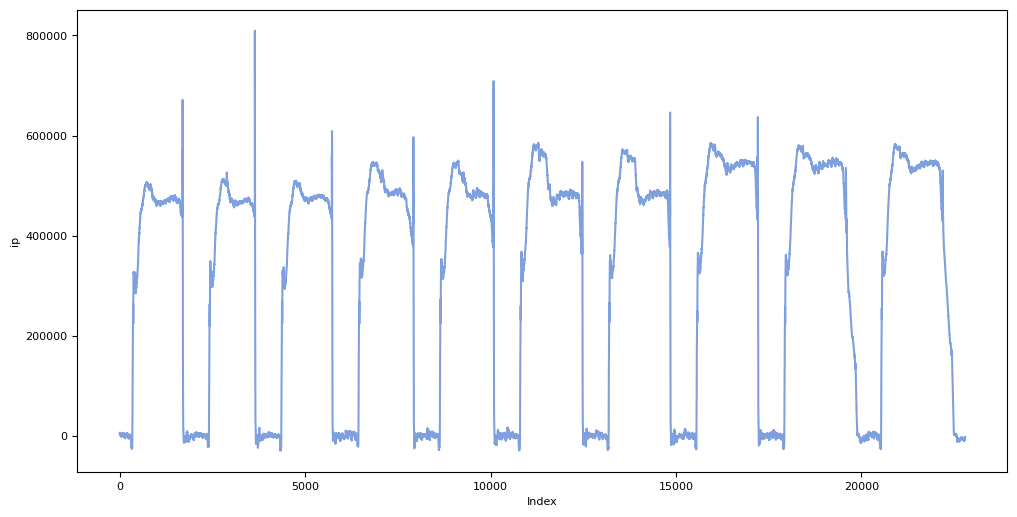

In [95]:
var_plot = variable_vs_timestamp[variable]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(var_plot.values, alpha=0.7)
ax.set_xlabel("Index")
ax.set_ylabel(variable)
plt.show()

In [96]:
variable_presence

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M01,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M02,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M03,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M04,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M05,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M08,False,False,True,True,True,True,True,True,True,False
b_field_tor_probe_saddle_field::ASM_SAD/M09,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M10,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False


In [97]:
variable_presence_vectorized

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M01,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M02,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M03,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M04,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M05,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M08,False,False,True,True,True,True,True,True,True,False
b_field_tor_probe_saddle_field::ASM_SAD/M09,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M10,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False


In [98]:
variable_presence_parallel

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M01,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M02,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M03,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M04,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M05,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_field::ASM_SAD/M08,False,False,True,True,True,True,True,True,True,False
b_field_tor_probe_saddle_field::ASM_SAD/M09,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M10,False,False,None,None,None,None,None,None,None,False
b_field_tor_probe_saddle_field::ASM_SAD/M11,False,False,None,None,None,None,None,None,None,False


In [99]:
def are_identical(variable_presence1, variable_presence2):
    """
    Check if two DataFrames are identical.
    """
    are_identical = variable_presence1.equals(variable_presence2)
    print(f"Identical dataframes ?  {are_identical}")

    if not are_identical:
        # Find differences
        diff_mask = variable_presence1 != variable_presence2
        diff_count = diff_mask.sum().sum()

        print(f"Total number of differences: {diff_count}")

        # If diff, percentage:
        total_cells = variable_presence1.size
        diff_percentage = (diff_count / total_cells) * 100
        print(f"D {diff_percentage:.2f}%")

In [100]:
print("Comparing variable_presence with variable_presence_vectorized:")
are_identical(variable_presence, variable_presence_vectorized)
print("\n===============================================\n")
print("Comparing variable_presence with variable_presence_parallel:")
are_identical(variable_presence, variable_presence_parallel)

Comparing variable_presence with variable_presence_vectorized:
Identical dataframes ?  True


Comparing variable_presence with variable_presence_parallel:
Identical dataframes ?  True


#### All shot scraping

Prediction of running time:

* For 100 shots on 'magnetics' group, the parallel function took 0:53 minutes.
* Thus (for 11281 shots), we expect a run time of 1 hour and 39 minutes.

In [101]:
variable_presence_all = check_variable_presence_parallel(
    shots=shots, 
    group=group, 
    verbose=True,
    max_workers=None)

Use of 6 workers (type: cpu)


Checking variables (parallel):  63%|██████▎   | 7157/11281 [1:46:14<2:02:36,  1.78s/it]

Error processing b_field_pol_probe_cc_field in shot 23534: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)Error processing b_field_pol_probe_ccbv_field in shot 23531: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Retrying connection to 23583 in group magnetics (attempt 1/3)

Error processing flux_loop_flux in shot 23535: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Retrying connection to 23536 in group magnetics (attempt 1/3)
Retr

Checking variables (parallel):  63%|██████▎   | 7158/11281 [1:46:15<1:49:13,  1.59s/it]

Error processing b_field_pol_probe_obr_field in shot 23535: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing b_field_pol_probe_ccbv_field in shot 23534: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Retrying connection to 23585 in group magnetics (attempt 1/3)
Error processing b_field_pol_probe_ccbv_field in shot 23535: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 23586 in group magnetics (attempt 1/3)
Retrying connection to 23583 in group magnetics (attempt 2/3)
Retrying connection to 23537 in group magnetics (attempt 2/3)Retrying connection to 23536 in group magnetics (attempt 2/3)
Retrying connection to 23584 in group magnetics (attempt 2/3)



Checking variables (parallel):  84%|████████▎ | 9428/11281 [3:02:24<1:51:18,  3.60s/it]

Error processing b_field_tor_probe_saddle_voltage in shot 27436: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)Error processing b_field_pol_probe_ccbv_field in shot 27432: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing b_field_tor_probe_omaha_voltage in shot 27433: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)

Error processing flux_loop_flux in shot 27434: Response payload is not completed: <ContentLengthError: 40

Checking variables (parallel):  84%|████████▎ | 9429/11281 [3:02:25<1:25:08,  2.76s/it]

Error processing b_field_tor_probe_saddle_field in shot 27433: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing flux_loop_flux in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing b_field_tor_probe_omaha_voltage in shot 27434: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_cc_field in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_field in shot 27433: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_omv_voltage in shot 27434: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 27441 in group magnetics (attempt 1/3)
Error processing ip in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo fa

Checking variables (parallel):  84%|████████▎ | 9431/11281 [3:02:26<46:36,  1.51s/it]  

Error processing b_field_pol_probe_obr_field in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 27442 in group magnetics (attempt 1/3)
Error processing b_field_tor_probe_saddle_field in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_field in shot 27436: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 27443 in group magnetics (attempt 1/3)
Retrying connection to 27438 in group magnetics (attempt 2/3)
Retrying connection to 27437 in group magnetics (attempt 2/3)
Retrying connection to 27440 in group magnetics (attempt 2/3)


Checking variables (parallel):  92%|█████████▏| 10344/11281 [3:52:32<39:38,  2.54s/it]  

Error processing b_field_tor_probe_cc_field in shot 29026: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)Error processing b_field_tor_probe_omaha_voltage in shot 29023: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing b_field_tor_probe_omaha_voltage in shot 29022: Response payload is not completed: <ContentLengthError: 400, message='Not enough data to satisfy content length header.'>. ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)
Error processing b_field_pol_probe_cc_field in shot 29025: Response payload is not completed: <ContentLengthE

Checking variables (parallel):  92%|█████████▏| 10345/11281 [3:52:41<1:04:53,  4.16s/it]

Error processing b_field_pol_probe_omv_voltage in shot 29022: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing b_field_pol_probe_omv_voltage in shot 29023: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing ip in shot 29025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_field in shot 29021: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_obv_field in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Retrying connection to 29028 in group magnetics (attempt 1/3)
Error processing b_field_pol_probe_omv_voltage in shot 29025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_obr_field in shot 29023: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [get

Checking variables (parallel):  92%|█████████▏| 10346/11281 [3:52:42<50:07,  3.22s/it]  

Error processing b_field_tor_probe_saddle_field in shot 29022: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]Error processing b_field_pol_probe_cc_field in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_saddle_field in shot 29023: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]

Error processing b_field_pol_probe_obr_field in shot 29025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_saddle_field in shot 29025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_field in shot 29022: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing ip in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_fie

Checking variables (parallel):  92%|█████████▏| 10348/11281 [3:52:42<30:19,  1.95s/it]

Retrying connection to 29030 in group magnetics (attempt 1/3)Retrying connection to 29029 in group magnetics (attempt 1/3)

Error processing b_field_pol_probe_ccbv_field in shot 29025: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_tor_probe_omaha_voltage in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 29031 in group magnetics (attempt 1/3)
Error processing b_field_pol_probe_omv_voltage in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_obr_field in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]


Checking variables (parallel):  92%|█████████▏| 10349/11281 [3:52:43<24:26,  1.57s/it]

Error processing b_field_tor_probe_saddle_field in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Error processing b_field_pol_probe_ccbv_field in shot 29026: Cannot connect to host s3.echo.stfc.ac.uk:443 ssl:default [getaddrinfo failed]
Retrying connection to 29032 in group magnetics (attempt 1/3)


Checking variables (parallel): 100%|██████████| 11281/11281 [4:39:20<00:00,  1.49s/it]  


In [102]:
variable_presence_all

,11766,11767,11768,11769,11771,11772,11773,11774,11775,11776,...,30462,30463,30464,30465,30466,30467,30468,30469,30470,30471
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M01,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M02,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M03,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M04,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M05,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M08,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M09,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M10,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
b_field_tor_probe_saddle_voltage::XMB/SAD/OUT/M11,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
file_path = f"notebooks/result_files/all_shots_{group}"
path = pathlib.Path().absolute().parent.parent.parent / file_path / f"variable_presence_all_shots_{group}.csv"
variable_presence_all.to_csv(path, index=True)

In [ ]:
# Visualization of variable presence
from matplotlib.colors import ListedColormap


def plot_variable_presence(variable_presence_all: pd.DataFrame, group: str = group, plot: bool = True, register: bool = False, register_name: str = "foo.png") -> None:
    """
    Plot the presence of variables across all shots in a group.

    Parameters
    variable_presence_all: pd.DataFrame
        DataFrame with variable presence across shots.
    group: str
        Diagnostic group name (e.g., "magnetics").
    plot: bool
        If True, display the plot.
    register: bool
        If True, save the plot to a file.
    register_name: str
        Name of the file to save the plot (if register is True).

    Returns
    None    
    """
    
    # Create an integer matrix for colormapping: 0 = False, 1 = True
    plot_df = variable_presence_all.fillna(False).infer_objects(copy=False)
    plot_matrix = plot_df.to_numpy()
    int_matrix = plot_matrix.astype(int)

    # Dimensions
    n_vars, n_shots = int_matrix.shape

    # Colors: 0 = red, 1 = green
    cmap = ListedColormap(["#4caf50", "#f44336"])  # green for True, red for False

    # Plot
    fig, ax = plt.subplots(figsize=(n_shots * 0.01, max(16, n_vars * 0.25)))
    im = ax.imshow(~int_matrix, aspect='auto', cmap=cmap, interpolation='none')


    ax.set_yticks(np.arange(n_vars))
    ax.set_yticklabels(variable_presence_all.index)
    ax.set_xticks(np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int))
    ax.set_xticklabels([variable_presence_all.columns[i] for i in np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int)], rotation=90)
    ax.set_xlabel("Shot ID")
    ax.set_ylabel("Variable::Channel")
    ax.set_title("Variable Presence Across Shots (green = present, red = missing)")
    ax.grid(False, axis='x')
    ax.set_yticks(np.arange(n_vars + 1) - 0.5, minor=True)
    ax.grid(True, axis='y', which='minor', color='gray', linestyle='--')

    if register:
        file_path = f"notebooks/result_files/all_shots_{group}"
        path = pathlib.Path().absolute().parent.parent.parent / file_path / register_name
        plt.savefig(path, dpi="figure")
        print(f"Plot saved to {path}")
    if plot:
        plt.show()
    return None

C:\Users\brussel\AppData\Local\Temp\ipykernel_15196\2950912221.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = variable_presence_all.fillna(False).infer_objects(copy=False)


Plot saved to c:\Users\brussel\Documents\1.ITER_Internship\ITER-magnetics-diagnostic-analysis\src\magnetics_diagnostic_analysis\results\variable_presence_magnetics.png


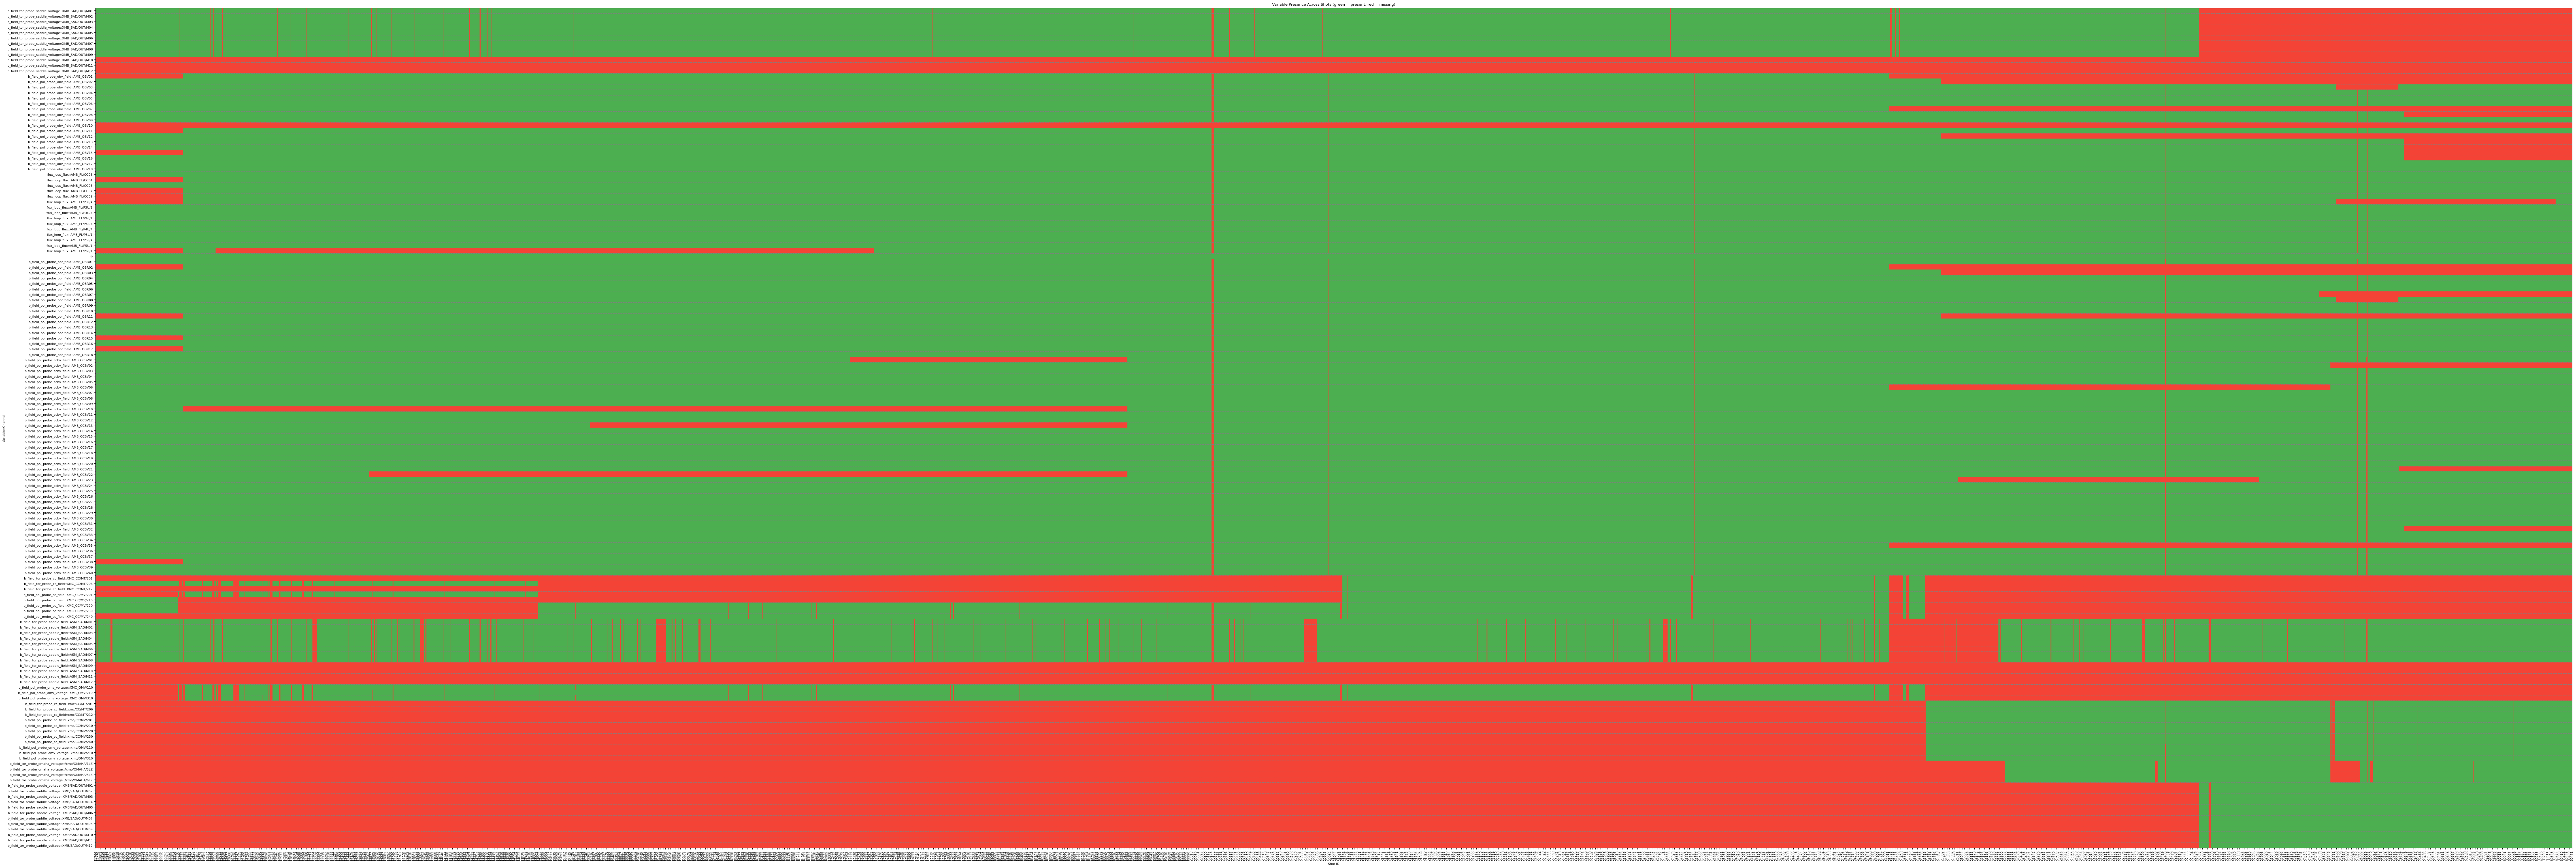

In [105]:
plot_variable_presence(variable_presence_all, group=group, plot=True, register=True, register_name=f"variable_presence_{group}.png")

### 7. Selection of shots and variables in good health

In [ ]:
def check_variable_presence_all(path: str, group: str = group, shot_threshold: float = 0.99, var_threshold: float = 0.8) -> list:
    """
    Select the good shots and variables::channels to avoid the presence of too many NaNs in the dataset.

    Parameters
    path: str
        Path to the CSV file containing variable presence data.

    Returns
    list(
        good_shots: list of shot IDs that are present in enough variables.
        bad_shots: list of shot IDs that are missing too many variables.
        good_vars: list of variable::channel names that are present in enough shots.
        bad_vars: list of variable::channel names that are missing too many shots.)
    """
    # Load the variable presence DataFrame
    path = pathlib.Path().absolute().parent.parent.parent / path
    df = pd.read_csv(path, index_col=0)
    df = df.fillna(False).infer_objects(copy=False)

    # Then delete the variables::channels for which at least 50% of the content is True. And store them in an array.
    bad_vars = df.index[df.sum(axis=1) < (len(df.columns) * var_threshold)].tolist()
    df = df.drop(index=bad_vars)
    plot_variable_presence(df, group=group, plot=True, register=False)

    # First delete the shots for which all variables are False. And store them in an array.
    bad_shots = df.columns[df.sum(axis=0) < (len(df.index) * shot_threshold)].tolist()
    df = df.drop(columns=bad_shots)
    plot_variable_presence(df, group=group, plot=True, register=True, register_name=f'variable_presence_{group}_filtered.png')


    return [
        df.columns.tolist(),    # Good shots
        bad_shots,              # Bad shots
        df.index.tolist(),      # Good variables::channels
        bad_vars                # Bad variables::channels
        ]

C:\Users\brussel\AppData\Local\Temp\ipykernel_15196\3285183172.py:18: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254

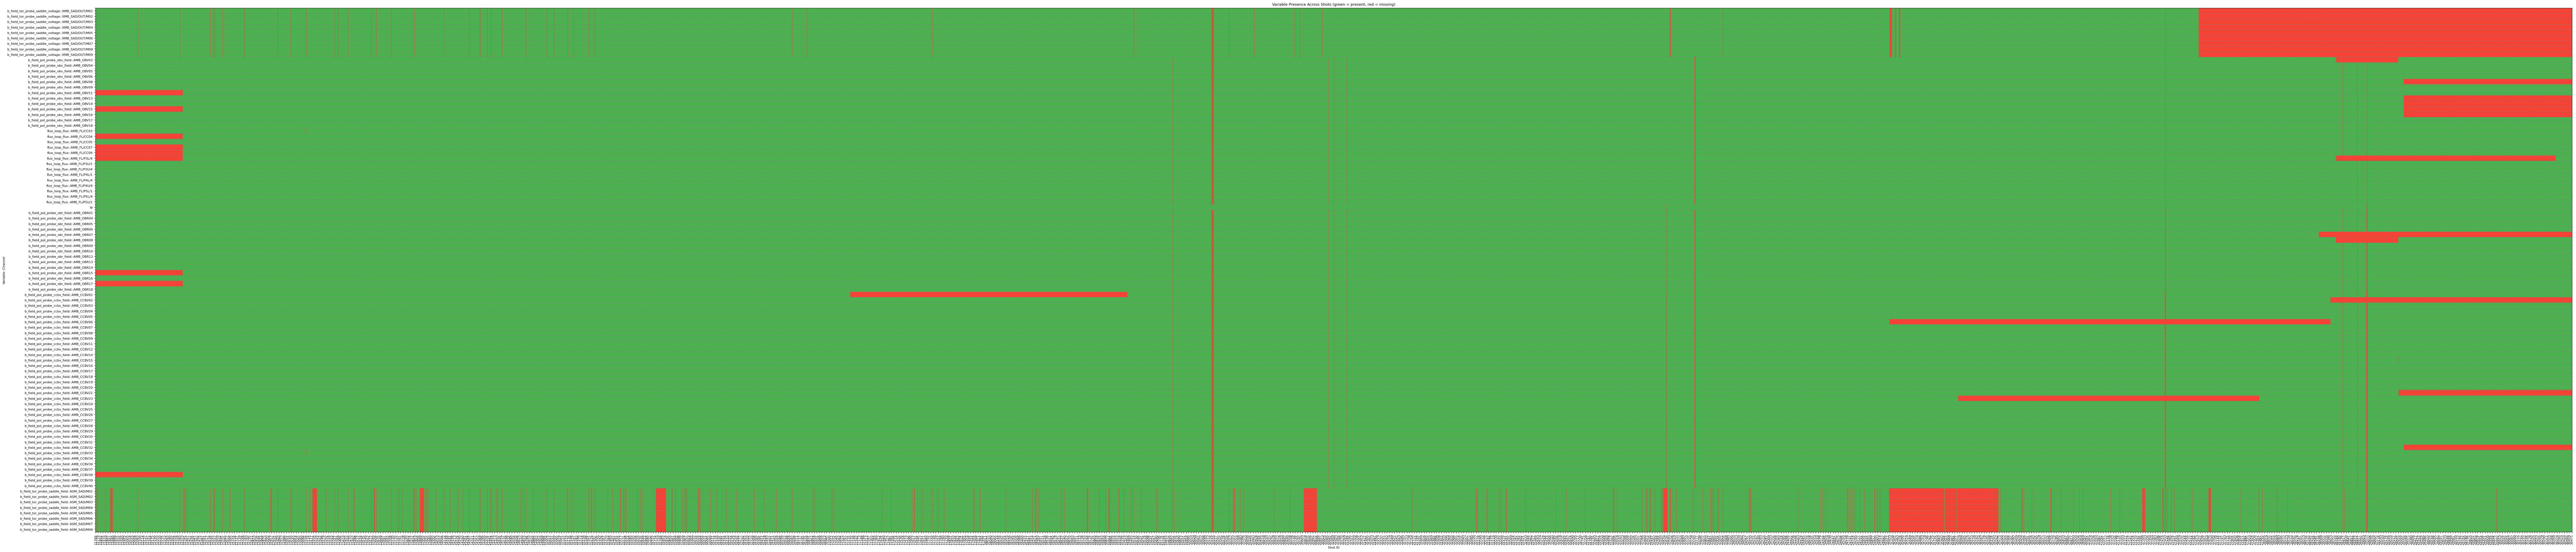

Plot saved to c:\Users\brussel\Documents\1.ITER_Internship\ITER-magnetics-diagnostic-analysis\src\magnetics_diagnostic_analysis\results\variable_presence_magnetics_filtered.png


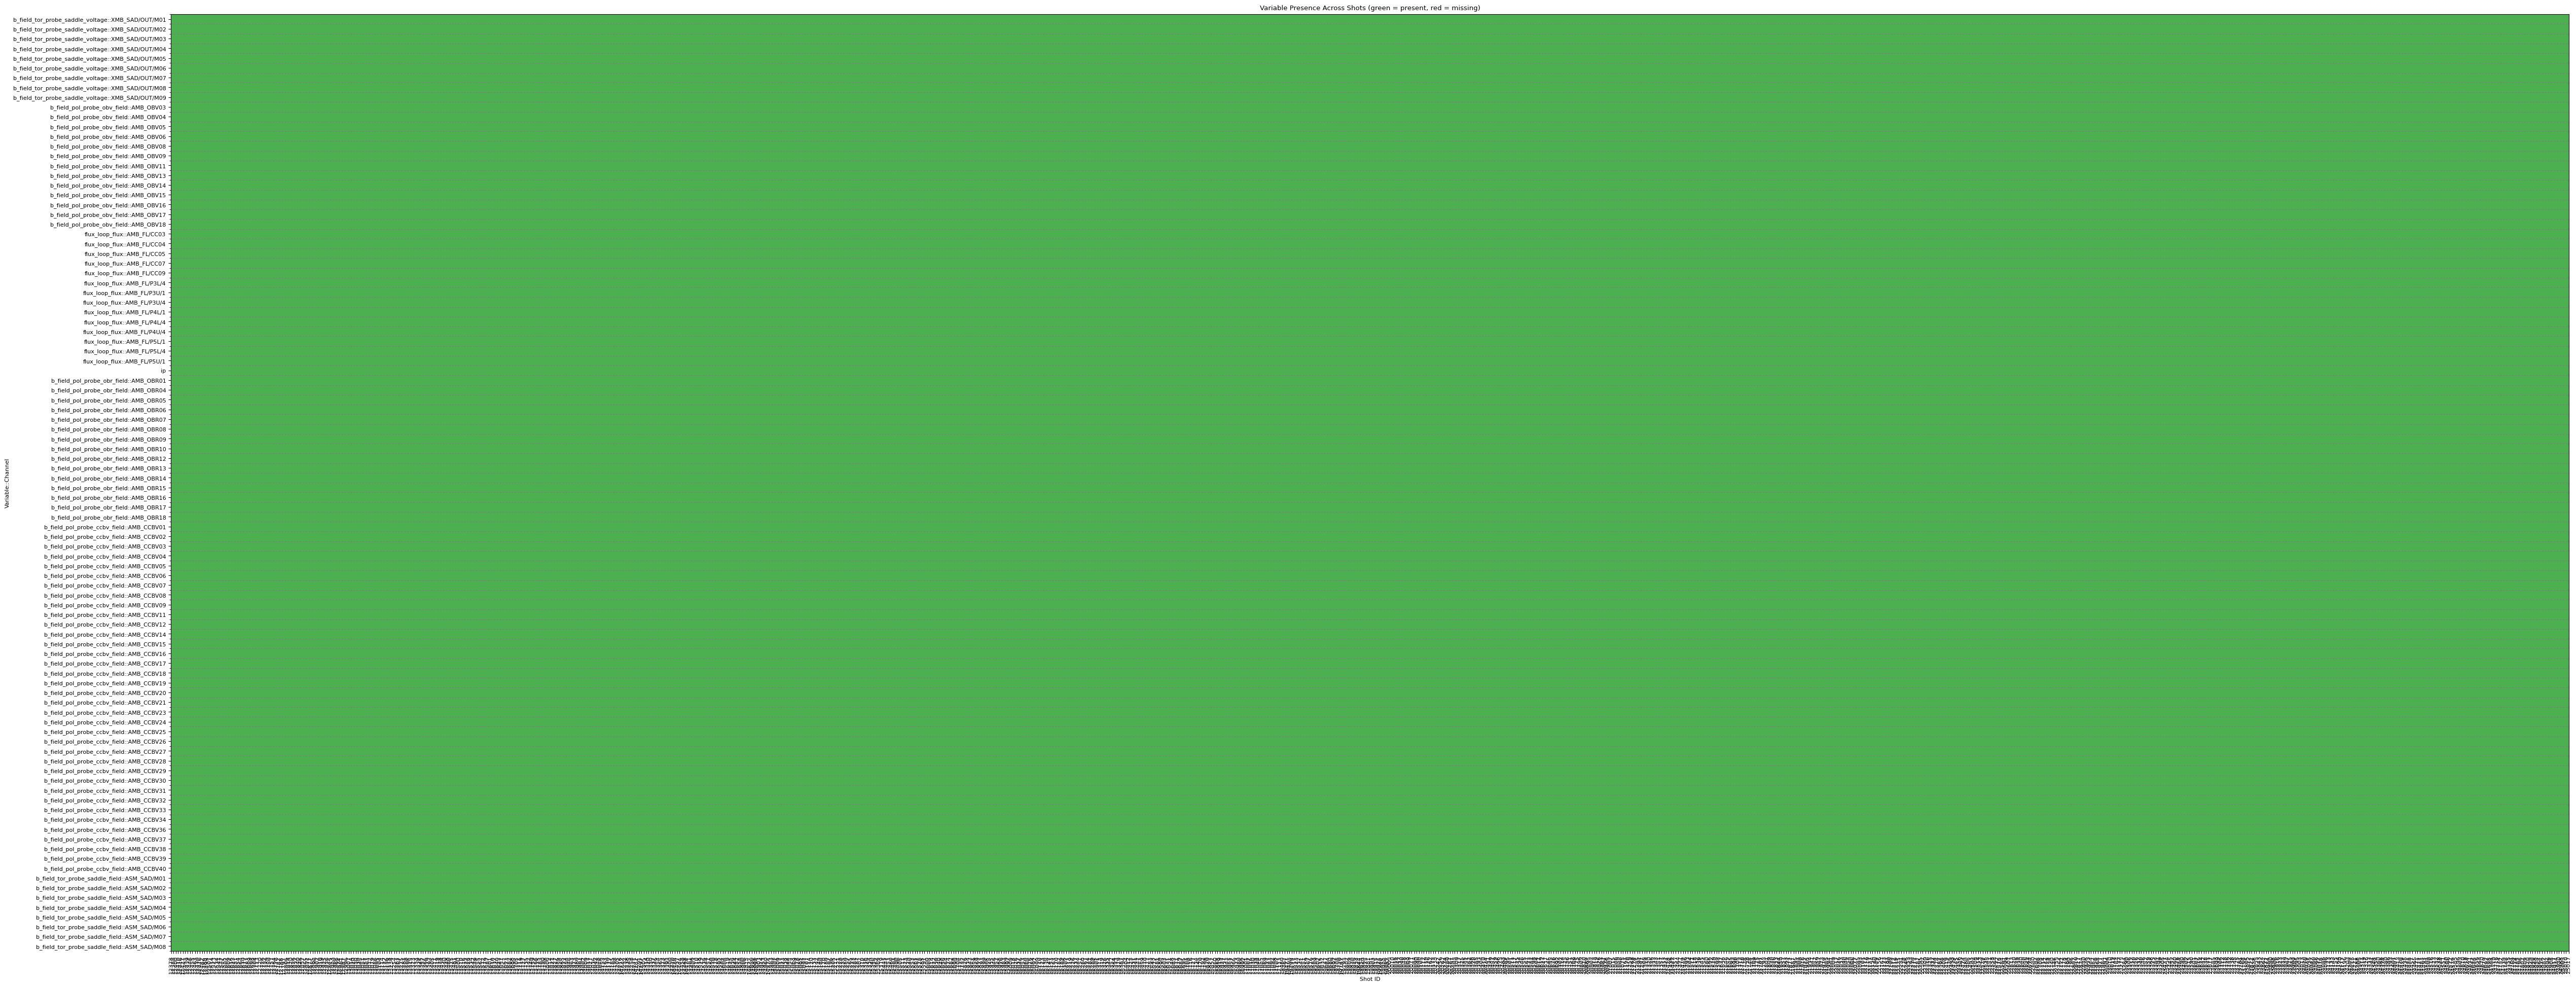

Number of bad variable::channel IDs: 58
Bad variable::channel IDs: ['b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M10', 'b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M11', 'b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M12', 'b_field_pol_probe_obv_field::AMB_OBV01', 'b_field_pol_probe_obv_field::AMB_OBV02', 'b_field_pol_probe_obv_field::AMB_OBV07', 'b_field_pol_probe_obv_field::AMB_OBV10', 'b_field_pol_probe_obv_field::AMB_OBV12', 'flux_loop_flux::AMB_FL/P6L/1', 'b_field_pol_probe_obr_field::AMB_OBR02', 'b_field_pol_probe_obr_field::AMB_OBR03', 'b_field_pol_probe_obr_field::AMB_OBR11', 'b_field_pol_probe_ccbv_field::AMB_CCBV10', 'b_field_pol_probe_ccbv_field::AMB_CCBV13', 'b_field_pol_probe_ccbv_field::AMB_CCBV22', 'b_field_pol_probe_ccbv_field::AMB_CCBV35', 'b_field_tor_probe_cc_field::XMC_CC/MT/201', 'b_field_tor_probe_cc_field::XMC_CC/MT/206', 'b_field_tor_probe_cc_field::XMC_CC/MT/212', 'b_field_pol_probe_cc_field::XMC_CC/MV/201', 'b_field_pol_probe_cc_field::XMC_CC/MV/210', 'b_f

In [ ]:
good_shot_ids, bad_shot_ids, good_vars_ids, bad_vars_ids = check_variable_presence_all(
    path=f"notebooks/result_files/all_shots_{group}/variable_presence_all_shots_{group}.csv",
    group=group,
    shot_threshold=0.99,
    var_threshold=0.8)

print(f"Number of bad variable::channel IDs: {len(bad_vars_ids)}")
print("Bad variable::channel IDs:", bad_vars_ids[:25])

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:25])



In [ ]:
data = {
    "good_shot_ids": good_shot_ids,
    "bad_shot_ids": bad_shot_ids,
    "goobad_vars_ids": good_vars_ids,
    "bad_vars_ids": bad_vars_ids,
}

path = pathlib.Path().absolute().parent.parent.parent / f"notebooks/result_files/all_shots_{group}"
file_name = path / f"result_lists{group}.json"
with open(file_name, "w") as f:
    json.dump(data, f, indent=4)

### 8. What are the `cpf_*` variables ?

In [108]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')

In [109]:
print(type(shots_df["cpf_p03249"]))
print("\n")
print(shots_df["cpf_p03249"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p03249, Length: 11281, dtype: object


In [110]:
print(type(shots_df["cpf_p04673"]))
print("\n")
print(shots_df["cpf_p04673"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p04673, Length: 11281, dtype: object


#### *Conclusion:*

*After having tryed many, they are all None.*

### 9. --------